# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import scipy.integrate as integrate

import porepy as pp
import pygeon as pg

import sympy as sp

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


For a manual import:

import sys
sys.path.append('/path/to/repository')

In [3]:
from utilities.assembly_utilities import find_ordering, local_A, local_Mh, transoform_nodal_func_to_physical_element
from richards.model_params import Model_Data
from richards.plot_exporter import Plot_Exporter
from richards.csv_exporter import Csv_Exporter

### Parameters

In [4]:
# Set the maximum number of iterations of the non-linear solver
K = 500

# L-scheme parameter
L = 3.501e-2 #0.1

# Set the mesh refinment
N = 40

# Set the number of steps (excluding the initial condition)
num_steps = 27

quad_order = 3

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-10
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'lagrange_hard_coupling'

In [5]:
def initial_h(x): return 1

In [6]:
# Van Genuchten model parameters ( relative permeability model )
model_data = Model_Data(theta_r=0.131, theta_s=0.396, alpha=0.423, n=2.06, K_s=4.96e-2, T=T, num_steps=num_steps)

In [7]:
# Time step
dt   = (T-0)/num_steps

### Mesh

In [8]:
bottom_grid =   pp.StructuredTriangleGrid([2*N, N], [2, 1])
bottom_grid.compute_geometry()

In [9]:
top_grid    = pp.StructuredTriangleGrid([2*N, 2*N], [2, 2])
top_grid.compute_geometry()

In [10]:
boundary_grid, boundary_face_map, boundary_node_map  = pp.partition.extract_subgrid(bottom_grid, 
                                                                                    bottom_grid.face_centers[1, :] == 1, 
                                                                                    faces=True)

### Discretization

In [11]:
key = "flow"

In [12]:
top_field = pg.Lagrange1(key)
top_data = {}

top_dof =  top_field.ndof( top_grid )

In [13]:
bottom_field = pg.Lagrange1(key)
bottom_data = {}

bottom_dof = bottom_field.ndof( bottom_grid )

In [14]:
boundary_field = pg.Lagrange1(key)
boundary_data = {}

boundary_dof = boundary_field.ndof( boundary_grid )

### Restrictor Matrices

In [15]:
bottom_delete_boundary_dof = np.zeros( shape=(bottom_dof - boundary_dof, bottom_dof) )
bottom_delete_boundary_dof[np.arange(bottom_dof - boundary_dof), bottom_grid.nodes[1, :] < 1] = 1
bottom_delete_boundary_dof = sps.csr_matrix(bottom_delete_boundary_dof)

In [16]:
bottom_isolate_boundary_dof = np.zeros(shape=(boundary_dof, bottom_dof))
bottom_isolate_boundary_dof[np.arange(boundary_dof), bottom_grid.nodes[1, :] == 1] = 1
bottom_isolate_boundary_dof = sps.csr_matrix(bottom_isolate_boundary_dof)

In [17]:
top_delete_boundary_dof = np.zeros( shape=(top_dof - boundary_dof, top_dof) )
top_delete_boundary_dof[np.arange(top_dof - boundary_dof), top_grid.nodes[1, :] > 0] = 1
top_delete_boundary_dof = sps.csr_matrix(top_delete_boundary_dof)

In [18]:
top_isolate_boundary_dof = np.zeros(shape=(boundary_dof, top_dof))
top_isolate_boundary_dof[np.arange(boundary_dof), top_grid.nodes[1, :] == 0] = 1
top_isolate_boundary_dof = sps.csr_matrix(top_isolate_boundary_dof)

### BCs

In [19]:
bot_dirichlet_flag  = np.array(np.logical_and( bottom_grid.nodes[0, :] == 2, bottom_grid.nodes[1, :] <= 1 ), dtype=bool)
bot_dirichlet_value = np.array(bot_dirichlet_flag, dtype=float)

In [20]:
top_dirichlet_flag  = np.array(np.logical_and( top_grid.nodes[1, :] == 2, top_grid.nodes[0, :] <= 1 ), dtype=bool)
top_dirichlet_value = lambda t: np.array(top_dirichlet_flag, dtype=float) * min( 6.2, 1 + 5.2 * t / dt_D )

In [21]:
dirichlet_flag  = np.hstack(( bot_dirichlet_flag, top_dirichlet_flag, np.zeros(shape=boundary_dof, dtype=bool)))
dirichlet_value = lambda t: np.hstack(( bot_dirichlet_value, top_dirichlet_value(t), np.zeros(shape=boundary_dof, dtype=bool)))

### Matrix Assembly

##### Projection matrices

In [22]:
top_proj    = top_field.eval_at_cell_centers( top_grid )
bottom_proj = bottom_field.eval_at_cell_centers( bottom_grid )

##### Stifness

In [23]:
def bottom_stifness_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        A = local_A(coord_loc, lambda x,y: model_data.K_s * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [24]:
def top_stifness_gen(h_dofs):
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        h_func = transoform_nodal_func_to_physical_element(h_dofs[nodes_loc], coord_loc)
        A = local_A(coord_loc, lambda x,y: model_data.hydraulic_conductivity_coefficient(h_func(x,y), 1+y) * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

##### Mass

In [25]:
def bottom_mass_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [26]:
def top_mass_gen():
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

### Solving stage

In [27]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [28]:
# assemble initial solution
initial_solution = np.zeros(top_dof + bottom_dof + boundary_dof)

In [29]:
bottom_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_mask[ : (bottom_dof) ] = True

top_mask = np.zeros_like(initial_solution, dtype=bool)
top_mask[(bottom_dof) : (bottom_dof + top_dof)] = True

lambda_mask = np.zeros_like(bottom_mask, dtype=bool)
lambda_mask[(bottom_dof + top_dof):] = True

In [30]:
initial_solution[top_mask]    =    top_field.interpolate(   top_grid, lambda x: 1)
initial_solution[bottom_mask] = bottom_field.interpolate(bottom_grid, lambda x: 1)

In [31]:
top_saver    = pp.Exporter(top_grid,    "top_sol", folder_name=output_directory)
bottom_saver = pp.Exporter(bottom_grid, "bottom_sol", folder_name=output_directory)
plot_exp = Plot_Exporter(output_directory)

def save_step(current_sol, step):
    ins = list()

    ins.append((top_grid, "cell_h", top_proj @ current_sol[top_mask]))
    ins.append((top_grid, "cell_p", top_proj @ (current_sol[top_mask] - 1 - top_grid.nodes[1, :])))
    top_saver.write_vtu(ins, time_step=step)

    ins = list()

    ins.append((bottom_grid, "cell_h", bottom_proj @ current_sol[bottom_mask]))
    ins.append((bottom_grid, "cell_p", bottom_proj @ (current_sol[bottom_mask] - bottom_grid.nodes[1, :])))
    bottom_saver.write_vtu(ins, time_step=step)

    exporter = Csv_Exporter(os.path.join(output_directory, 'csv'), str(step) + '.csv', ['x', 'y', 'h', 'p'])

    xs = []
    ys = []
    hs = []

    tmp = np.hstack([current_sol[:(bottom_dof-boundary_dof)], current_sol[bottom_dof:(bottom_dof + top_dof)]])
    for x,y,h,p in zip(np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[0, :], top_grid.nodes[0, :]]),
                       np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1]),
                       tmp,
                       tmp - np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1])):
        xs.append(x)
        ys.append(y)
        hs.append(h)

        exporter.add_entry([x,y,h,p])

    plot_exp.export_surface(np.array(xs), np.array(ys), np.array(hs), str(step), shape_x=2*N+1, shape_y=3*N+1, show=True)

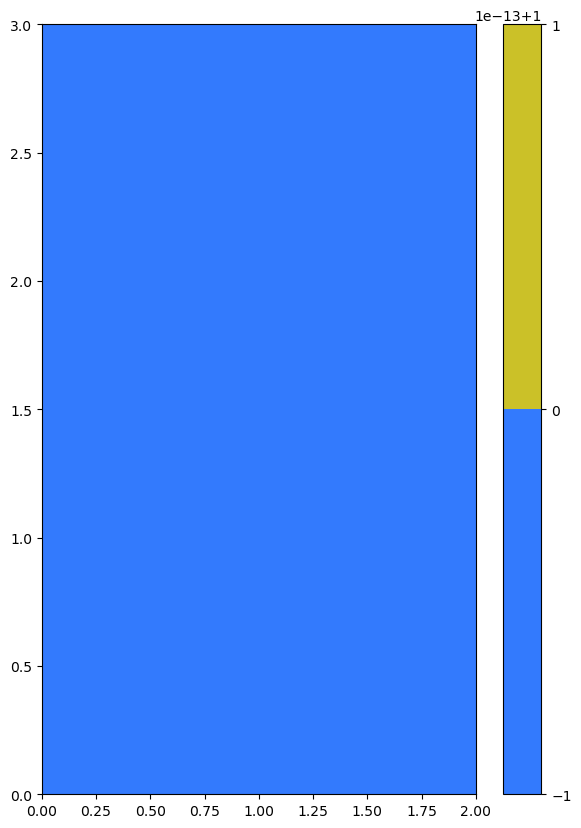

In [32]:
# solve the problem

sol = [initial_solution]

t = 0

save_step(sol[-1], 0)

In [33]:
def bottom_normal_continuity_matrix():
    data = []
    cols = []
    rows = []
    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        if np.abs(np.max(coord_loc[1, :]) - 1) < 1e-7:
            
            ordering, m = find_ordering(coord_loc)

            if m < 0:
                eta_cell = np.max(np.where( boundary_grid.nodes[0, :] < bottom_grid.cell_centers[0, c] ))

                ordered_coords = coord_loc[:, ordering]

                x0 = ordered_coords[:, 0]
                x1 = ordered_coords[:, 1]
                x2 = ordered_coords[:, 2]
                
                q_funcs = [model_data.K_s * np.array([-1/(x2[0] - x0[0]), -1/(x1[1] - x0[1])]), 
                           model_data.K_s * np.array([                 0,  1/(x1[1] - x0[1])]), 
                           model_data.K_s * np.array([ 1/(x2[0] - x0[0]),                  0])]
            
                for i in range(3):
                    rows.append(eta_cell)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

                    rows.append(eta_cell+1)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

    
    return sps.coo_matrix((np.array(data), (np.array(rows), np.array(cols))), shape=(boundary_dof, bottom_grid.num_nodes))

In [34]:
def top_normal_continuity_matrix(h_dofs):
    data = []
    cols = []
    rows = []
    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        if np.abs(np.min(coord_loc[1, :]) - 0) < 1e-7:
            ordering, m = find_ordering(coord_loc)

            if m > 0:
                eta_cell = np.max(np.where( boundary_grid.nodes[0, :] < top_grid.cell_centers[0, c] ))

                ordered_coords = coord_loc[:, ordering]

                h_ord = h_dofs[nodes_loc][ordering]

                x0 = ordered_coords[:, 0]
                x1 = ordered_coords[:, 1]
                x2 = ordered_coords[:, 2]

                h_mean = (h_ord[0] + h_ord[2]) / 2

                q_funcs = [model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([-1/(x2[0] - x0[0]), -1/(x1[1] - x0[1])]), 
                           model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([                 0,  1/(x1[1] - x0[1])]), 
                           model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([ 1/(x2[0] - x0[0]),                  0])]
            
                for i in range(3):
                    rows.append(eta_cell)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

                    rows.append(eta_cell+1)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

    
    return sps.coo_matrix((np.array(data), (np.array(rows), np.array(cols))), shape=(boundary_dof, top_grid.num_nodes))

In [35]:
top_mass = top_mass_gen()
bottom_mass_gen = bottom_mass_gen()

In [36]:
bottom_stifness = bottom_stifness_gen()

In [37]:
M_gamma = boundary_field.assemble_mass_matrix(boundary_grid)

In [38]:
bot_lagrange = M_gamma @ bottom_isolate_boundary_dof
top_lagrange = M_gamma @ top_isolate_boundary_dof

Time 0.02083
Iteration #0001, error L2 relative psi:    0.14696163358360


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in power
  return select([less(h, z),True], [0.265*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.514563106796116) + 0.131,0.396], default=nan)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar power
  return select([less(h, z),True], [0.0496*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)**2*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.257281553398058),0.0496], default=nan)


Iteration #0002, error L2 relative psi:    0.05833214660554
Iteration #0003, error L2 relative psi:    0.01951082255406
Iteration #0004, error L2 relative psi:    0.00350735051727
Iteration #0005, error L2 relative psi:    0.00089267733110
Iteration #0006, error L2 relative psi:    0.00027258511090
Iteration #0007, error L2 relative psi:    0.00004286335524
Iteration #0008, error L2 relative psi:    0.00001696258085
Iteration #0009, error L2 relative psi:    0.00000260771028


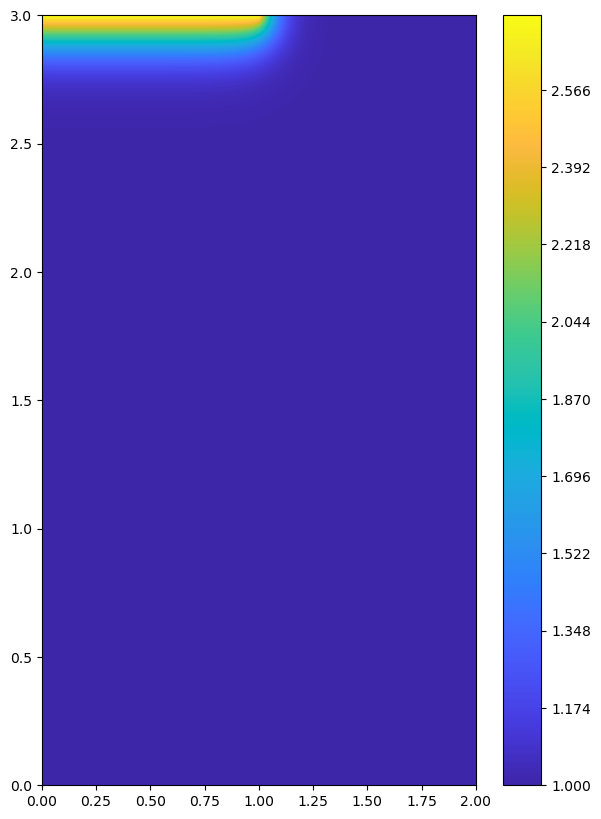


Time 0.04167
Iteration #0001, error L2 relative psi:    0.24083458744430
Iteration #0002, error L2 relative psi:    0.08389521083565
Iteration #0003, error L2 relative psi:    0.02913396773235
Iteration #0004, error L2 relative psi:    0.00793697285394
Iteration #0005, error L2 relative psi:    0.00282185796812
Iteration #0006, error L2 relative psi:    0.00106726145940
Iteration #0007, error L2 relative psi:    0.00026957782594
Iteration #0008, error L2 relative psi:    0.00009894003077
Iteration #0009, error L2 relative psi:    0.00003112645612
Iteration #0010, error L2 relative psi:    0.00000889455826


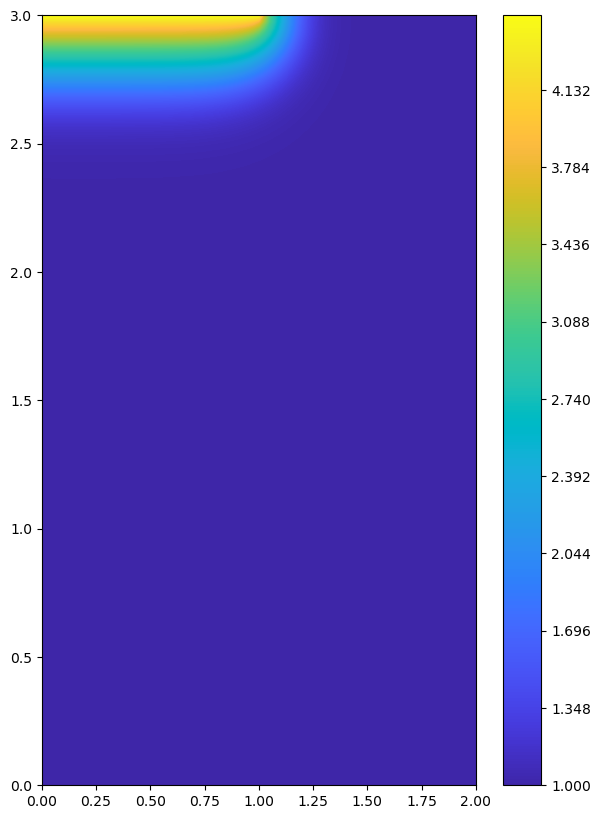


Time 0.0625
Iteration #0001, error L2 relative psi:    0.26354492982382
Iteration #0002, error L2 relative psi:    0.07018776963797
Iteration #0003, error L2 relative psi:    0.02602245270827
Iteration #0004, error L2 relative psi:    0.00846066857551
Iteration #0005, error L2 relative psi:    0.00232391623415
Iteration #0006, error L2 relative psi:    0.00065635071582
Iteration #0007, error L2 relative psi:    0.00028797537524
Iteration #0008, error L2 relative psi:    0.00013777344484
Iteration #0009, error L2 relative psi:    0.00006050176213
Iteration #0010, error L2 relative psi:    0.00002439204919
Iteration #0011, error L2 relative psi:    0.00000972579119


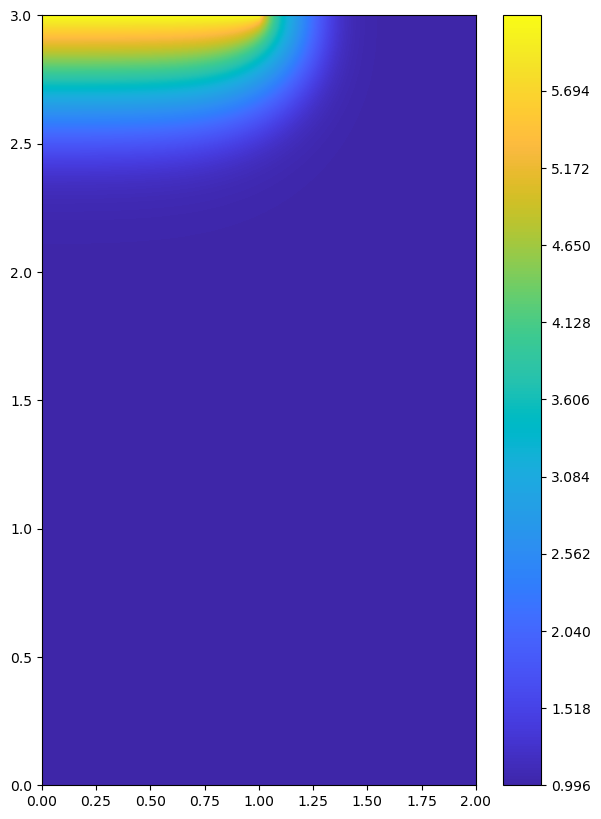


Time 0.08333
Iteration #0001, error L2 relative psi:    0.09441448960125
Iteration #0002, error L2 relative psi:    0.03445392179671
Iteration #0003, error L2 relative psi:    0.01542234347530
Iteration #0004, error L2 relative psi:    0.00758042895004
Iteration #0005, error L2 relative psi:    0.00411215852591
Iteration #0006, error L2 relative psi:    0.00237811348236
Iteration #0007, error L2 relative psi:    0.00140387263632
Iteration #0008, error L2 relative psi:    0.00083050508975
Iteration #0009, error L2 relative psi:    0.00049107439303
Iteration #0010, error L2 relative psi:    0.00029038528688
Iteration #0011, error L2 relative psi:    0.00017177269162
Iteration #0012, error L2 relative psi:    0.00010164216228
Iteration #0013, error L2 relative psi:    0.00006015778749
Iteration #0014, error L2 relative psi:    0.00003560950090
Iteration #0015, error L2 relative psi:    0.00002107987591
Iteration #0016, error L2 relative psi:    0.00001247926264
Iteration #0017, error L2 

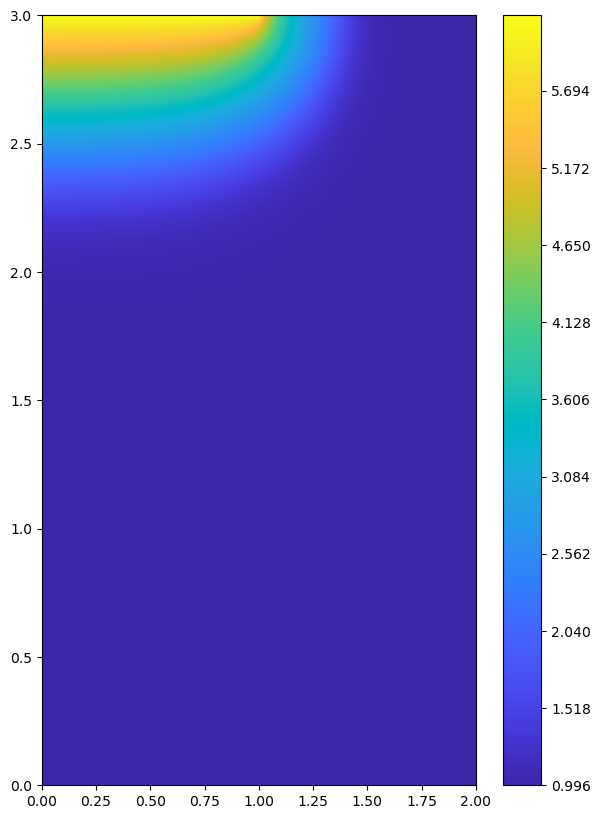


Time 0.10417
Iteration #0001, error L2 relative psi:    0.06229802922564
Iteration #0002, error L2 relative psi:    0.02250024079046
Iteration #0003, error L2 relative psi:    0.01172321973753
Iteration #0004, error L2 relative psi:    0.00713852133073
Iteration #0005, error L2 relative psi:    0.00469236741885
Iteration #0006, error L2 relative psi:    0.00318034087472
Iteration #0007, error L2 relative psi:    0.00218087898936
Iteration #0008, error L2 relative psi:    0.00150343292644
Iteration #0009, error L2 relative psi:    0.00103939831486
Iteration #0010, error L2 relative psi:    0.00071977098776
Iteration #0011, error L2 relative psi:    0.00049892614532
Iteration #0012, error L2 relative psi:    0.00034606462241
Iteration #0013, error L2 relative psi:    0.00024013888497
Iteration #0014, error L2 relative psi:    0.00016668369573
Iteration #0015, error L2 relative psi:    0.00011571986220
Iteration #0016, error L2 relative psi:    0.00008034913921
Iteration #0017, error L2 

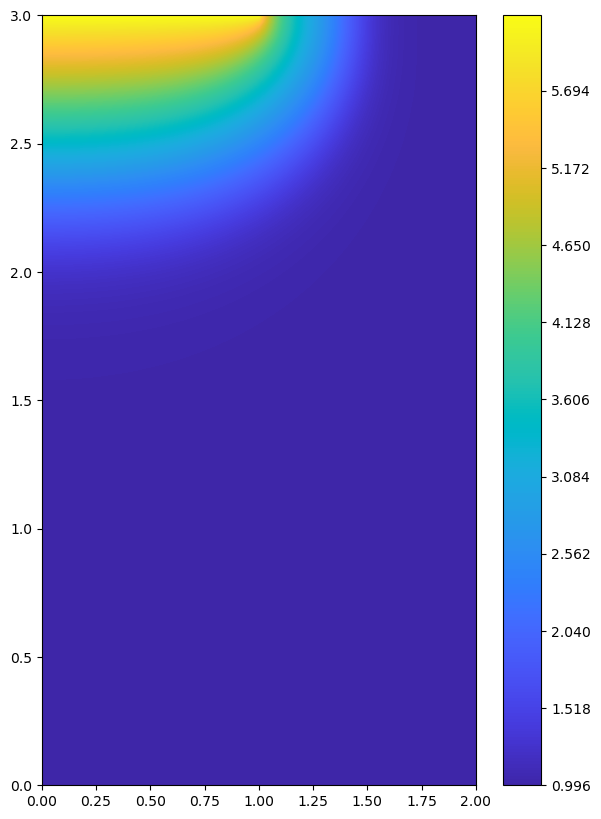


Time 0.125
Iteration #0001, error L2 relative psi:    0.04630777593132
Iteration #0002, error L2 relative psi:    0.01695730034219
Iteration #0003, error L2 relative psi:    0.00973843325322
Iteration #0004, error L2 relative psi:    0.00657648707315
Iteration #0005, error L2 relative psi:    0.00475028168016
Iteration #0006, error L2 relative psi:    0.00352555626724
Iteration #0007, error L2 relative psi:    0.00264957082812
Iteration #0008, error L2 relative psi:    0.00200454828586
Iteration #0009, error L2 relative psi:    0.00152246112101
Iteration #0010, error L2 relative psi:    0.00115909028785
Iteration #0011, error L2 relative psi:    0.00088381751291
Iteration #0012, error L2 relative psi:    0.00067463451993
Iteration #0013, error L2 relative psi:    0.00051534622080
Iteration #0014, error L2 relative psi:    0.00039387959803
Iteration #0015, error L2 relative psi:    0.00030115258346
Iteration #0016, error L2 relative psi:    0.00023031433717
Iteration #0017, error L2 re

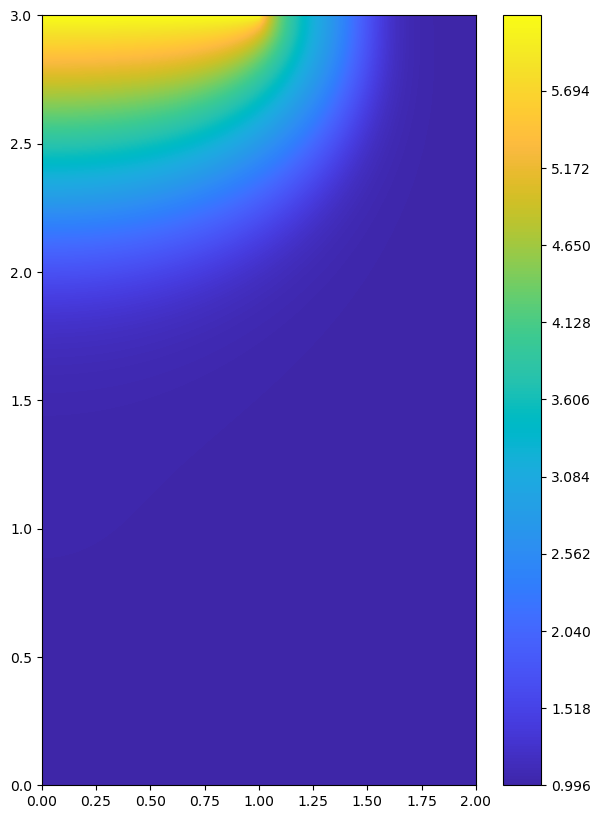


Time 0.14583
Iteration #0001, error L2 relative psi:    0.03637315184992
Iteration #0002, error L2 relative psi:    0.01407201816894
Iteration #0003, error L2 relative psi:    0.00882754821919
Iteration #0004, error L2 relative psi:    0.00640968060709
Iteration #0005, error L2 relative psi:    0.00494994647383
Iteration #0006, error L2 relative psi:    0.00392908998743
Iteration #0007, error L2 relative psi:    0.00316221203624
Iteration #0008, error L2 relative psi:    0.00256452283645
Iteration #0009, error L2 relative psi:    0.00208946269059
Iteration #0010, error L2 relative psi:    0.00170759521371
Iteration #0011, error L2 relative psi:    0.00139852237853
Iteration #0012, error L2 relative psi:    0.00114720739381
Iteration #0013, error L2 relative psi:    0.00094219638885
Iteration #0014, error L2 relative psi:    0.00077455417587
Iteration #0015, error L2 relative psi:    0.00063721328490
Iteration #0016, error L2 relative psi:    0.00052453130685
Iteration #0017, error L2 

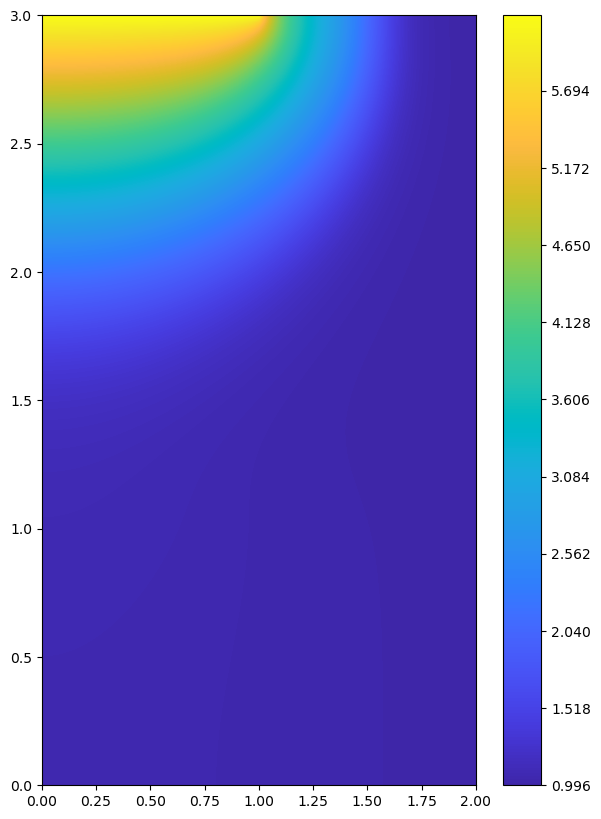


Time 0.16667
Iteration #0001, error L2 relative psi:    0.02944126017233
Iteration #0002, error L2 relative psi:    0.01270976291605
Iteration #0003, error L2 relative psi:    0.00932546839771
Iteration #0004, error L2 relative psi:    0.00773851207074
Iteration #0005, error L2 relative psi:    0.00673261900333
Iteration #0006, error L2 relative psi:    0.00598138521122
Iteration #0007, error L2 relative psi:    0.00537301651642
Iteration #0008, error L2 relative psi:    0.00485829844140
Iteration #0009, error L2 relative psi:    0.00440953252262
Iteration #0010, error L2 relative psi:    0.00401213307648
Iteration #0011, error L2 relative psi:    0.00365820244739
Iteration #0012, error L2 relative psi:    0.00334172046561
Iteration #0013, error L2 relative psi:    0.00305760379491
Iteration #0014, error L2 relative psi:    0.00280155838923
Iteration #0015, error L2 relative psi:    0.00257001730522
Iteration #0016, error L2 relative psi:    0.00235998942612
Iteration #0017, error L2 

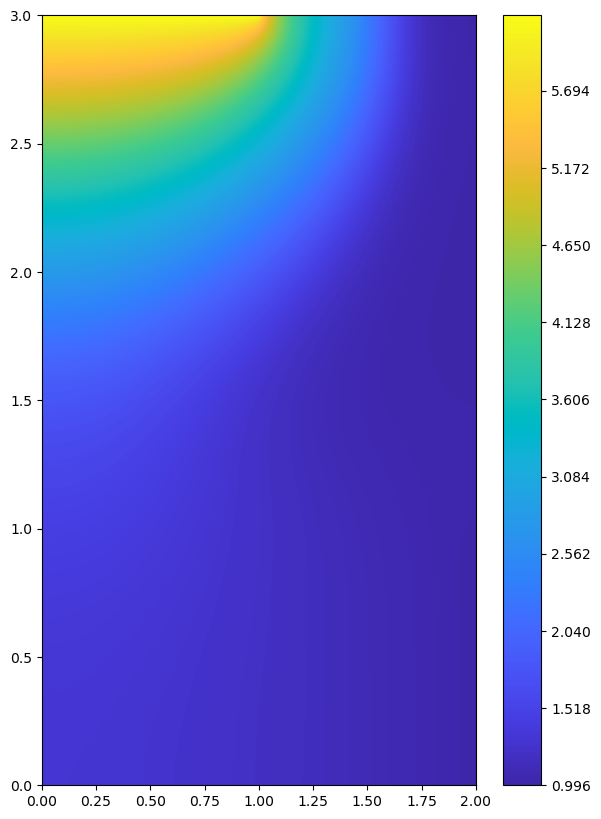


Time 0.1875
Iteration #0001, error L2 relative psi:    0.02378824138683
Iteration #0002, error L2 relative psi:    0.01089668067940
Iteration #0003, error L2 relative psi:    0.00903045893081
Iteration #0004, error L2 relative psi:    0.00818620742239
Iteration #0005, error L2 relative psi:    0.00758770116407
Iteration #0006, error L2 relative psi:    0.00707395533617
Iteration #0007, error L2 relative psi:    0.00660670071932
Iteration #0008, error L2 relative psi:    0.00617477255999
Iteration #0009, error L2 relative psi:    0.00577394398171
Iteration #0010, error L2 relative psi:    0.00540169223694
Iteration #0011, error L2 relative psi:    0.00505592804370
Iteration #0012, error L2 relative psi:    0.00473467394721
Iteration #0013, error L2 relative psi:    0.00443605098470
Iteration #0014, error L2 relative psi:    0.00415829336731
Iteration #0015, error L2 relative psi:    0.00389974815576
Iteration #0016, error L2 relative psi:    0.00365888561738
Iteration #0017, error L2 r

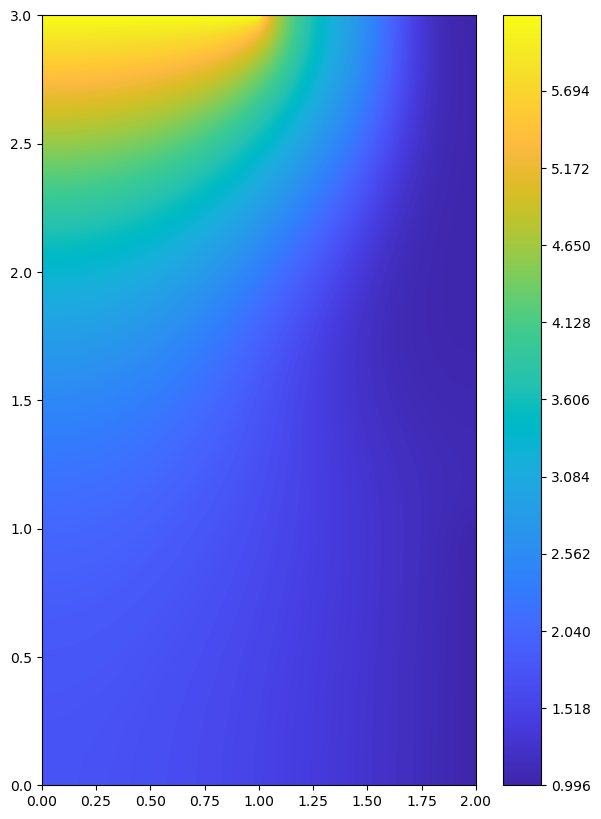


Time 0.20833
Iteration #0001, error L2 relative psi:    0.01980410519894
Iteration #0002, error L2 relative psi:    0.00754738436183
Iteration #0003, error L2 relative psi:    0.00542540877342
Iteration #0004, error L2 relative psi:    0.00444709713478
Iteration #0005, error L2 relative psi:    0.00386047770695
Iteration #0006, error L2 relative psi:    0.00345076449944
Iteration #0007, error L2 relative psi:    0.00314013576883
Iteration #0008, error L2 relative psi:    0.00289166310276
Iteration #0009, error L2 relative psi:    0.00268504889838
Iteration #0010, error L2 relative psi:    0.00250794011165
Iteration #0011, error L2 relative psi:    0.00235240439554
Iteration #0012, error L2 relative psi:    0.00221317898345
Iteration #0013, error L2 relative psi:    0.00208670370286
Iteration #0014, error L2 relative psi:    0.00197051959438
Iteration #0015, error L2 relative psi:    0.00186290214229
Iteration #0016, error L2 relative psi:    0.00176261462505
Iteration #0017, error L2 

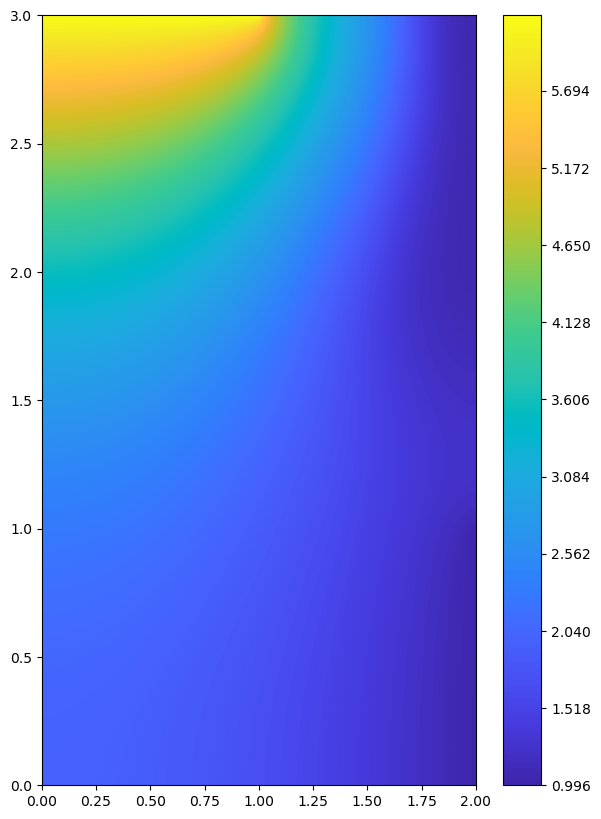


Time 0.22917
Iteration #0001, error L2 relative psi:    0.01767589143272
Iteration #0002, error L2 relative psi:    0.00583548079779
Iteration #0003, error L2 relative psi:    0.00394432812103
Iteration #0004, error L2 relative psi:    0.00309796593320
Iteration #0005, error L2 relative psi:    0.00261021276512
Iteration #0006, error L2 relative psi:    0.00228153037366
Iteration #0007, error L2 relative psi:    0.00204073624172
Iteration #0008, error L2 relative psi:    0.00185473377837
Iteration #0009, error L2 relative psi:    0.00170561752327
Iteration #0010, error L2 relative psi:    0.00158250110076
Iteration #0011, error L2 relative psi:    0.00147825174005
Iteration #0012, error L2 relative psi:    0.00138799944890
Iteration #0013, error L2 relative psi:    0.00130833918412
Iteration #0014, error L2 relative psi:    0.00123685415056
Iteration #0015, error L2 relative psi:    0.00117182019906
Iteration #0016, error L2 relative psi:    0.00111199740731
Iteration #0017, error L2 

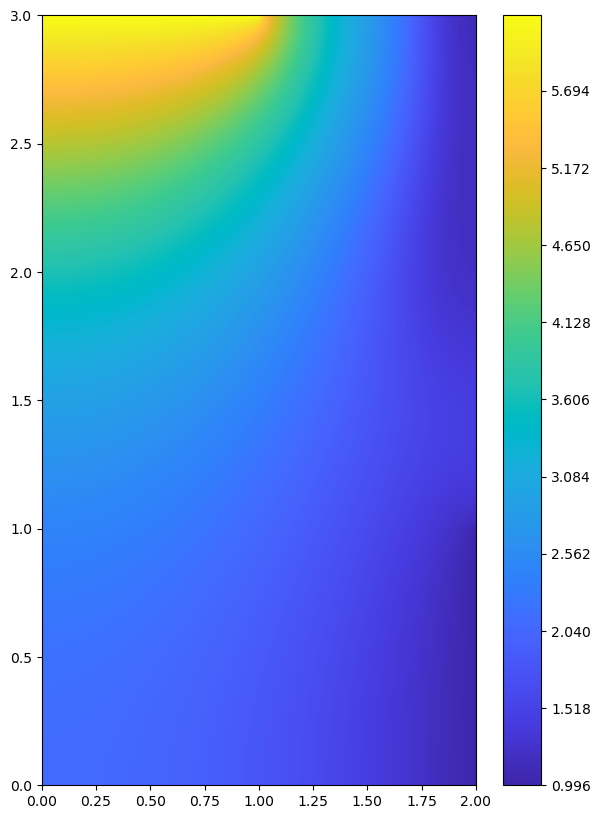


Time 0.25
Iteration #0001, error L2 relative psi:    0.01676497401830
Iteration #0002, error L2 relative psi:    0.00529813867153
Iteration #0003, error L2 relative psi:    0.00356324694338
Iteration #0004, error L2 relative psi:    0.00279222012829
Iteration #0005, error L2 relative psi:    0.00234578266375
Iteration #0006, error L2 relative psi:    0.00204461785872
Iteration #0007, error L2 relative psi:    0.00182341376364
Iteration #0008, error L2 relative psi:    0.00165214139742
Iteration #0009, error L2 relative psi:    0.00151472986332
Iteration #0010, error L2 relative psi:    0.00140153275186
Iteration #0011, error L2 relative psi:    0.00130625250287
Iteration #0012, error L2 relative psi:    0.00122453332133
Iteration #0013, error L2 relative psi:    0.00115325504593
Iteration #0014, error L2 relative psi:    0.00109012720768
Iteration #0015, error L2 relative psi:    0.00103345085193
Iteration #0016, error L2 relative psi:    0.00098195446016
Iteration #0017, error L2 rel

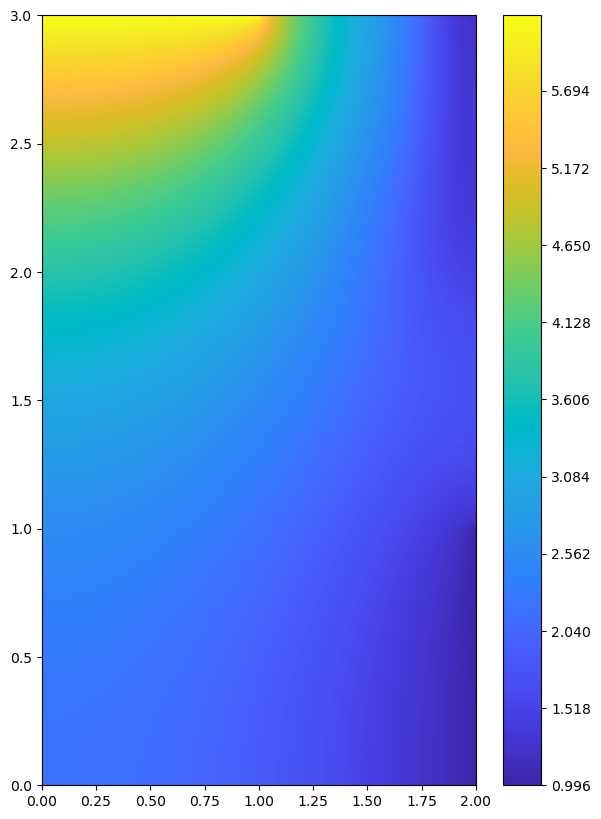


Time 0.27083
Iteration #0001, error L2 relative psi:    0.01626965832897
Iteration #0002, error L2 relative psi:    0.00557173176808
Iteration #0003, error L2 relative psi:    0.00382776900001
Iteration #0004, error L2 relative psi:    0.00304038527039
Iteration #0005, error L2 relative psi:    0.00257142027398
Iteration #0006, error L2 relative psi:    0.00225045222699
Iteration #0007, error L2 relative psi:    0.00201273070587
Iteration #0008, error L2 relative psi:    0.00182761479707
Iteration #0009, error L2 relative psi:    0.00167839895120
Iteration #0010, error L2 relative psi:    0.00155501455128
Iteration #0011, error L2 relative psi:    0.00145092440896
Iteration #0012, error L2 relative psi:    0.00136162683341
Iteration #0013, error L2 relative psi:    0.00128388942689
Iteration #0014, error L2 relative psi:    0.00121531695736
Iteration #0015, error L2 relative psi:    0.00115409727148
Iteration #0016, error L2 relative psi:    0.00109883692133
Iteration #0017, error L2 

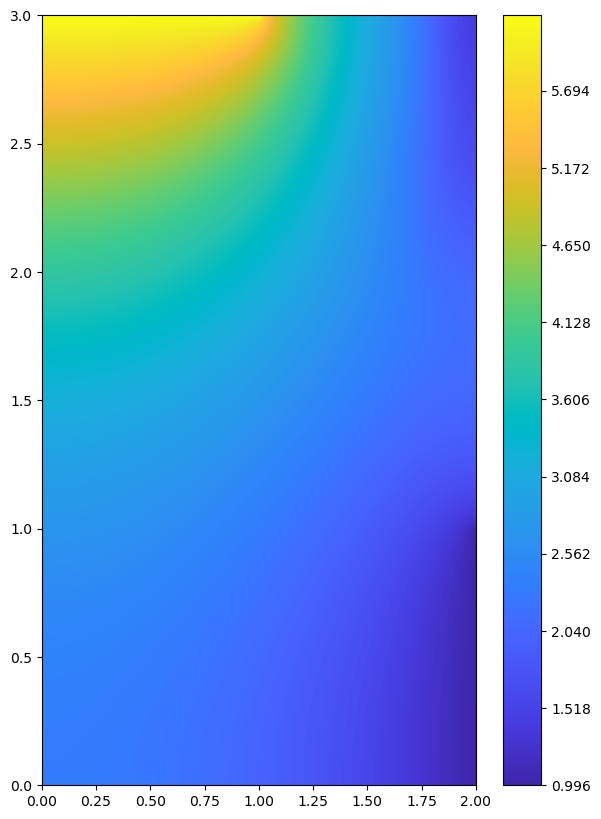


Time 0.29167
Iteration #0001, error L2 relative psi:    0.01531821441684
Iteration #0002, error L2 relative psi:    0.00619384047901
Iteration #0003, error L2 relative psi:    0.00440393394780
Iteration #0004, error L2 relative psi:    0.00355915020919
Iteration #0005, error L2 relative psi:    0.00303508591523
Iteration #0006, error L2 relative psi:    0.00266681920181
Iteration #0007, error L2 relative psi:    0.00238960141726
Iteration #0008, error L2 relative psi:    0.00217161000296
Iteration #0009, error L2 relative psi:    0.00199494185878
Iteration #0010, error L2 relative psi:    0.00184847983187
Iteration #0011, error L2 relative psi:    0.00172488899226
Iteration #0012, error L2 relative psi:    0.00161904933702
Iteration #0013, error L2 relative psi:    0.00152723280224
Iteration #0014, error L2 relative psi:    0.00144665343902
Iteration #0015, error L2 relative psi:    0.00137517819644
Iteration #0016, error L2 relative psi:    0.00131114365363
Iteration #0017, error L2 

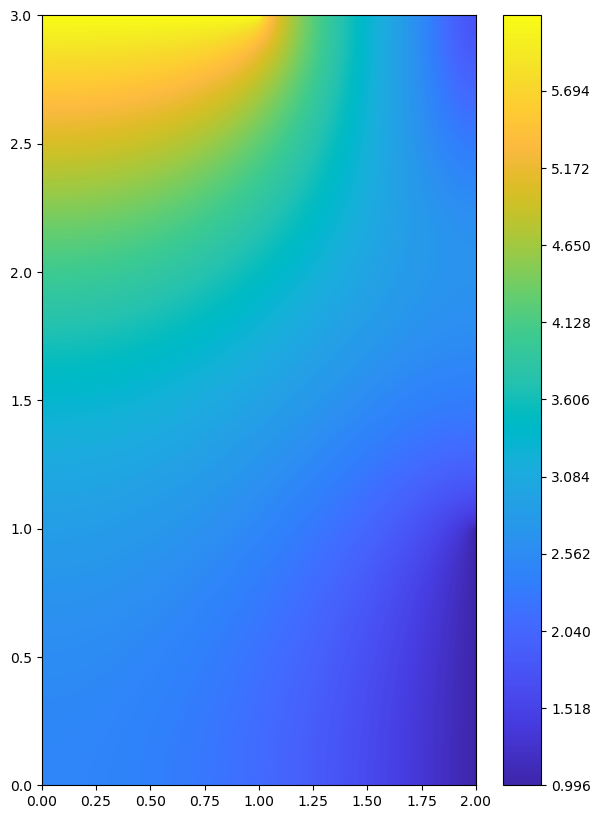


Time 0.3125
Iteration #0001, error L2 relative psi:    0.01355018527737
Iteration #0002, error L2 relative psi:    0.00688545472247
Iteration #0003, error L2 relative psi:    0.00514992844677
Iteration #0004, error L2 relative psi:    0.00429131894661
Iteration #0005, error L2 relative psi:    0.00374742796872
Iteration #0006, error L2 relative psi:    0.00335730987320
Iteration #0007, error L2 relative psi:    0.00305692321544
Iteration #0008, error L2 relative psi:    0.00281517504091
Iteration #0009, error L2 relative psi:    0.00261479489391
Iteration #0010, error L2 relative psi:    0.00244525108168
Iteration #0011, error L2 relative psi:    0.00229951250936
Iteration #0012, error L2 relative psi:    0.00217273187228
Iteration #0013, error L2 relative psi:    0.00206130699214
Iteration #0014, error L2 relative psi:    0.00196250642970
Iteration #0015, error L2 relative psi:    0.00187423501997
Iteration #0016, error L2 relative psi:    0.00179477036151
Iteration #0017, error L2 r

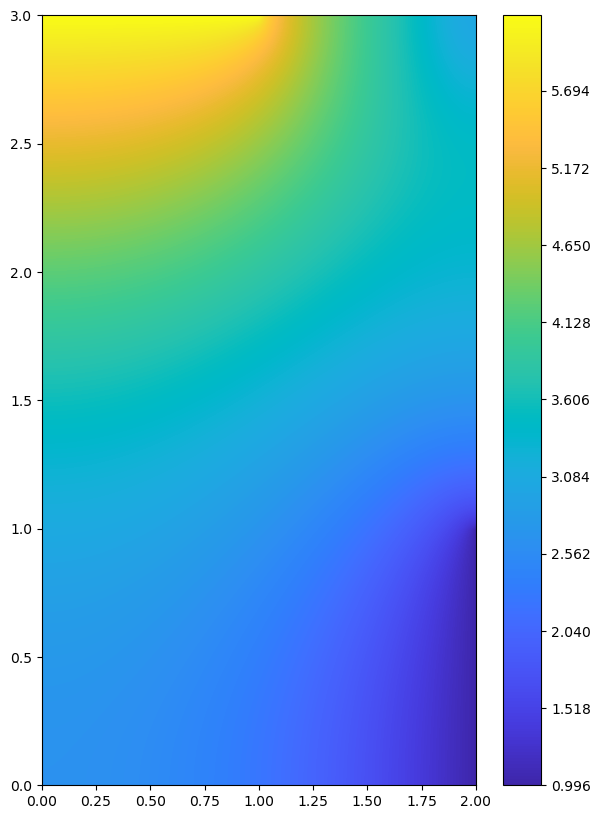


Time 0.33333
Iteration #0001, error L2 relative psi:    0.00779630068567
Iteration #0002, error L2 relative psi:    0.00566998967421
Iteration #0003, error L2 relative psi:    0.00460683098398
Iteration #0004, error L2 relative psi:    0.00395337160793
Iteration #0005, error L2 relative psi:    0.00349781003155
Iteration #0006, error L2 relative psi:    0.00315370288301
Iteration #0007, error L2 relative psi:    0.00287973134202
Iteration #0008, error L2 relative psi:    0.00265372068013
Iteration #0009, error L2 relative psi:    0.00246263502163
Iteration #0010, error L2 relative psi:    0.00229821804949
Iteration #0011, error L2 relative psi:    0.00215490657840
Iteration #0012, error L2 relative psi:    0.00202875297373
Iteration #0013, error L2 relative psi:    0.00191683206160
Iteration #0014, error L2 relative psi:    0.00181689674109
Iteration #0015, error L2 relative psi:    0.00172716876313
Iteration #0016, error L2 relative psi:    0.00164620662206
Iteration #0017, error L2 

KeyboardInterrupt: 

In [39]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    current_time = step * dt
    print('Time ' + str(round(current_time, 5)))
    
    time_rhs = np.zeros_like(sol[-1])

    time_rhs[top_mask] += top_mass @ model_data.theta(sol[-1][top_mask], 1 + top_grid.nodes[1,:]) / dt

    prev = sol[-1]

    for k in range(K):
        rhs = time_rhs.copy()

        rhs[top_mask] += L * top_mass @ prev[top_mask] / dt
        rhs[top_mask] -= top_mass @ model_data.theta(prev[top_mask], 1 + top_grid.nodes[1,:]) / dt

        bottom_mat = bottom_stifness
        top_stifness = top_stifness_gen(prev[top_mask])

        top_mat = top_stifness + L / dt * top_mass
        top_vel = top_normal_continuity_matrix(prev[top_mask])

        spp = sps.bmat([[  bottom_mat,          None,  bot_lagrange.T],
                        [        None,       top_mat, -top_lagrange.T],
                        [bot_lagrange, -top_lagrange,            None]], format='csc')
        
        ls = pg.LinearSystem(spp, rhs)

        #print(spp, rhs)

        ls.flag_ess_bc(dirichlet_flag, dirichlet_value(current_time))

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev).T @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ prev )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi / abs_err_prev, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break

    sol.append( current )

    save_step(sol[-1], step)
    print('')    